In [ ]:
!pip install pmdarima
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

stock_data = pd.read_csv(
    '/content/acgl.us.txt',
    sep=',',
    index_col='Date',
    parse_dates=['Date'],
    date_parser=lambda dates: pd.to_datetime(dates, format='%Y-%m-%d')  ).fillna(0)
stock_data

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2005-02-25,13.583,13.693,13.430,13.693,156240,0
2005-02-28,13.697,13.827,13.540,13.827,370509,0
2005-03-01,13.780,13.913,13.720,13.760,224484,0
2005-03-02,13.717,13.823,13.667,13.810,286431,0
2005-03-03,13.783,13.783,13.587,13.630,193824,0
...,...,...,...,...,...,...
2017-11-06,94.490,95.650,94.020,95.550,420192,0
2017-11-07,95.860,95.950,95.200,95.560,464011,0
2017-11-08,95.410,95.900,94.890,95.450,471756,0


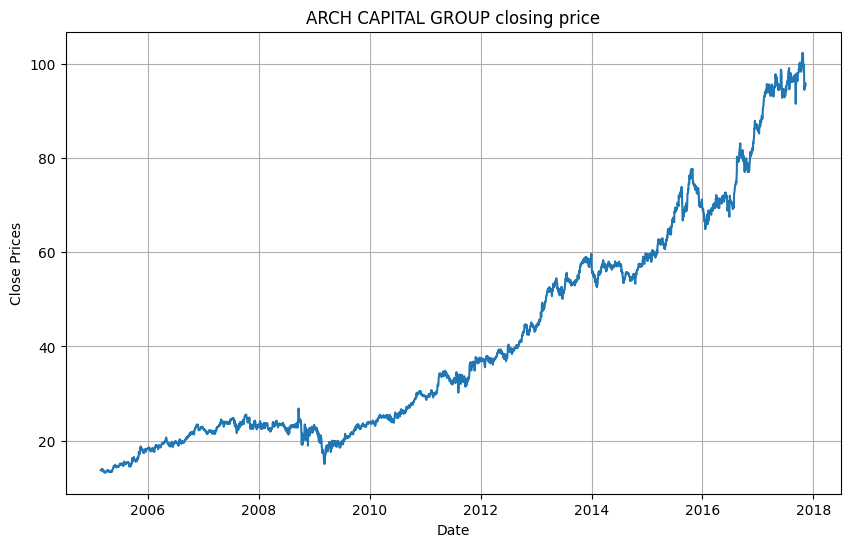

In [ ]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('ARCH CAPITAL GROUP closing price')
plt.show()

<Axes: ylabel='Density'>

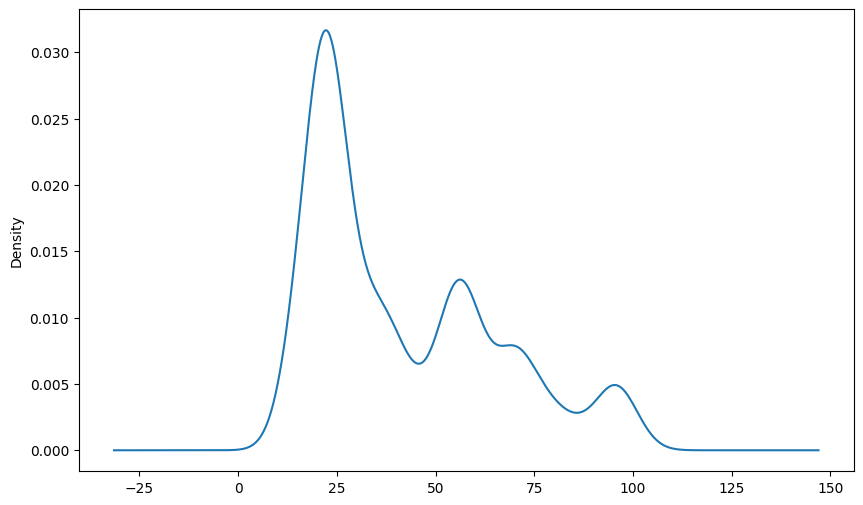

In [ ]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

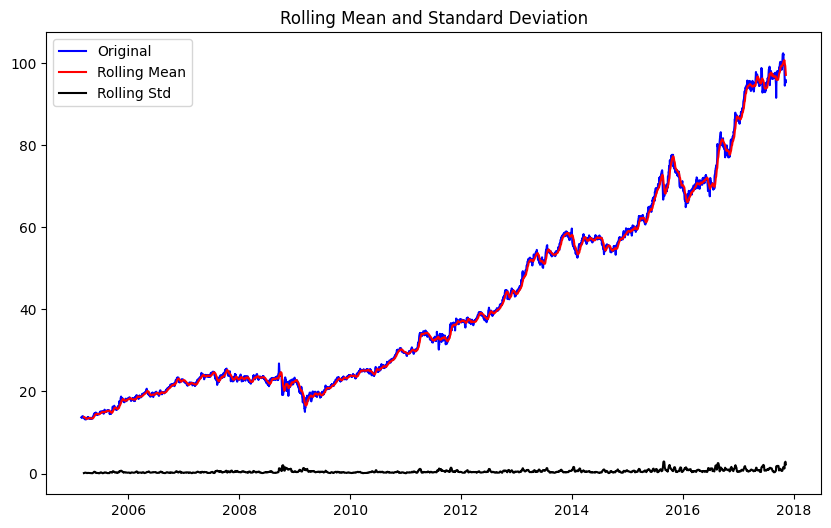

Results of dickey fuller test
Test Statistics                   1.374899
p-value                           0.996997
No. of lags used                  5.000000
Number of observations used    3195.000000
critical value (1%)              -3.432398
critical value (5%)              -2.862445
critical value (10%)             -2.567252
dtype: float64


In [ ]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Axes: ylabel='Density'>

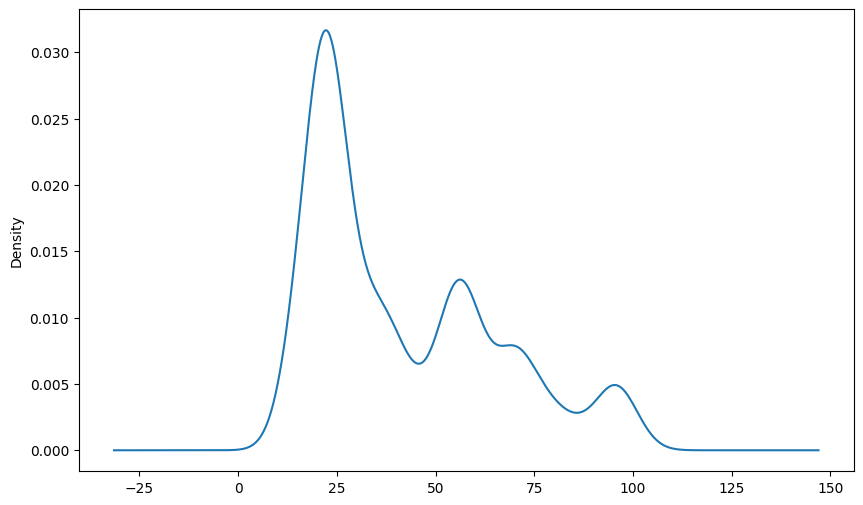

In [ ]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

<Figure size 1000x600 with 0 Axes>

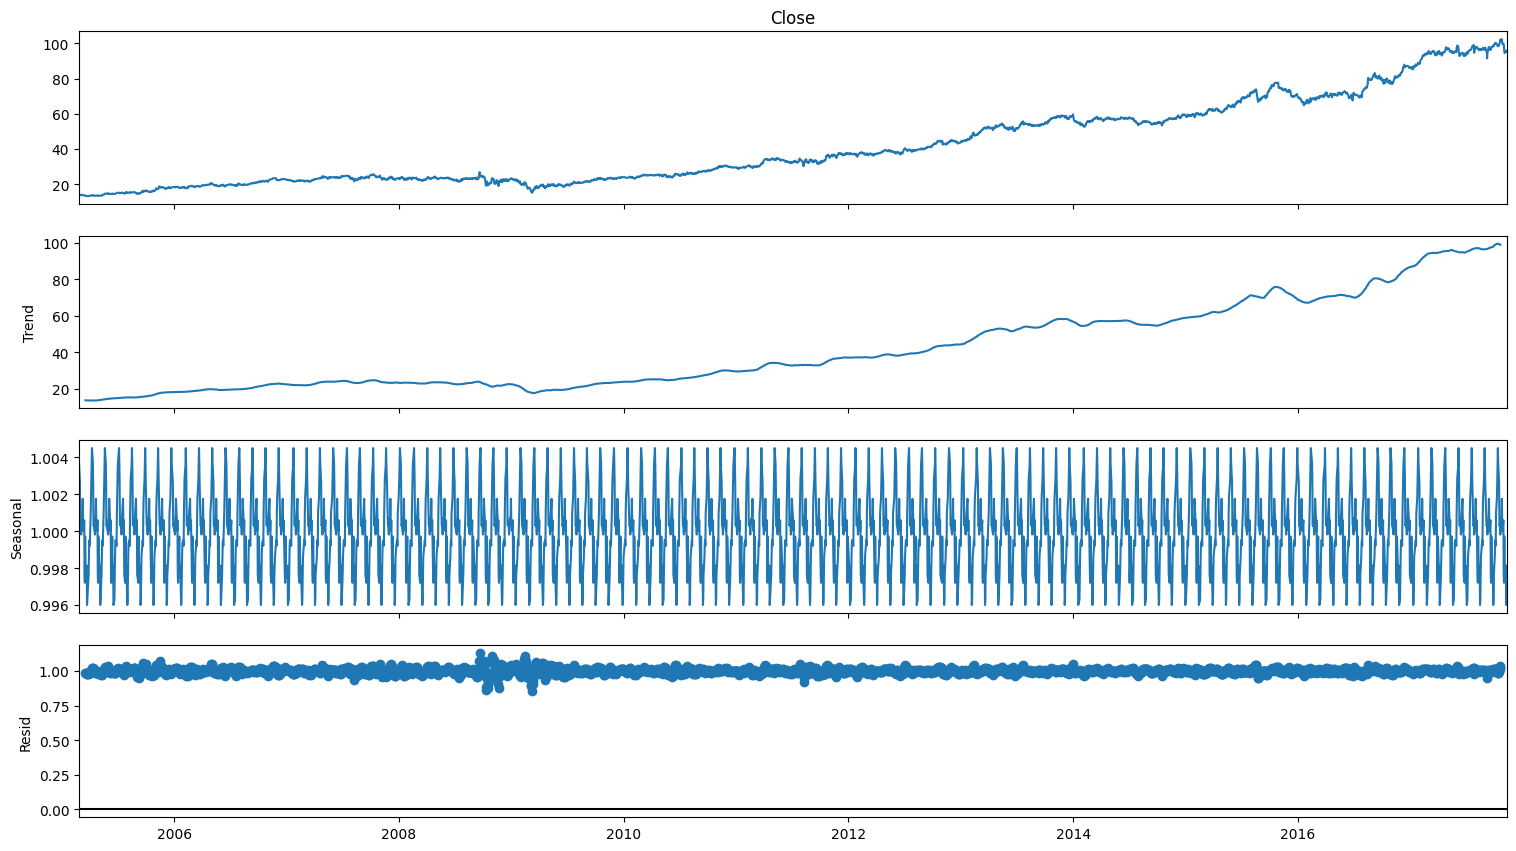

In [ ]:
#To separate the trend and the seasonality from a time series,
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period=30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

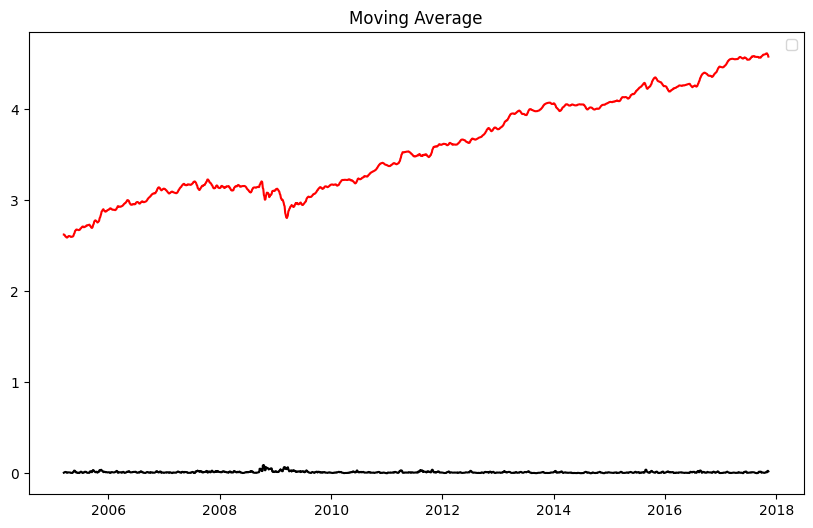

In [ ]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

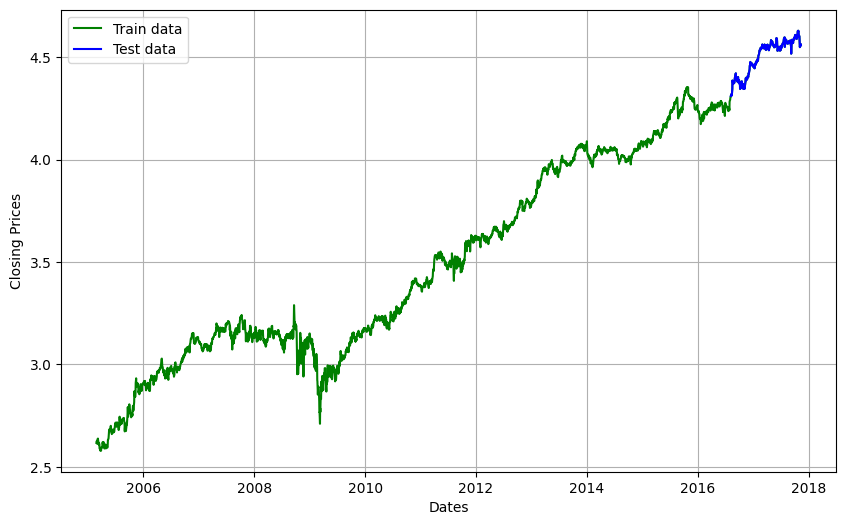

In [ ]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16491.508, Time=0.75 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16525.992, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16527.964, Time=4.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16488.323, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16527.157, Time=5.70 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-16527.120, Time=2.93 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-16528.810, Time=3.98 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=10.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-16526.020, Time=7.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-16524.974, Time=8.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16525.435, Time=1.44 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-16516.417, Time=0.95 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-16527.597, Time=0.88 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 47.014 seconds
 

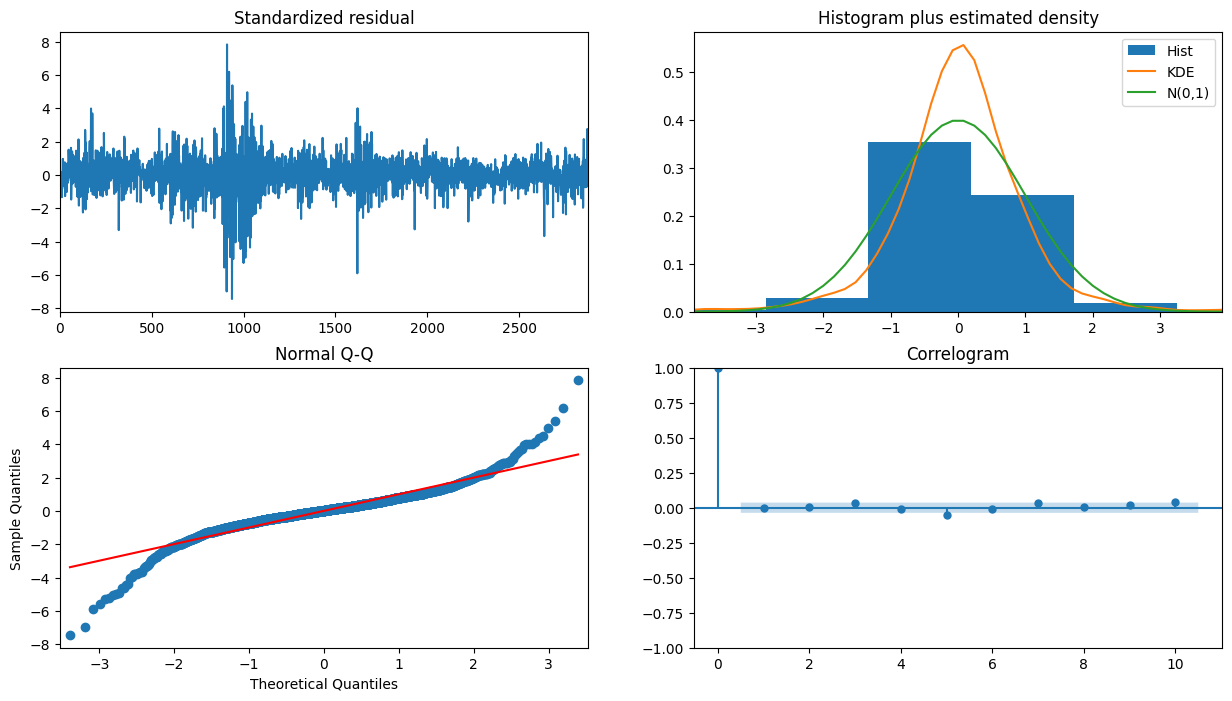

In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
model = ARIMA(train_data, order=(1,1,2))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2877
Model:                 ARIMA(1, 1, 2)   Log Likelihood                8267.798
Date:                Fri, 12 Jul 2024   AIC                         -16527.597
Time:                        06:50:57   BIC                         -16503.740
Sample:                             0   HQIC                        -16518.997
                               - 2877                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8973      0.036     24.798      0.000       0.826       0.968
ma.L1         -1.0130      0.039    -25.731      0.000      -1.090      -0.936
ma.L2          0.0826      0.014      5.842      0.0

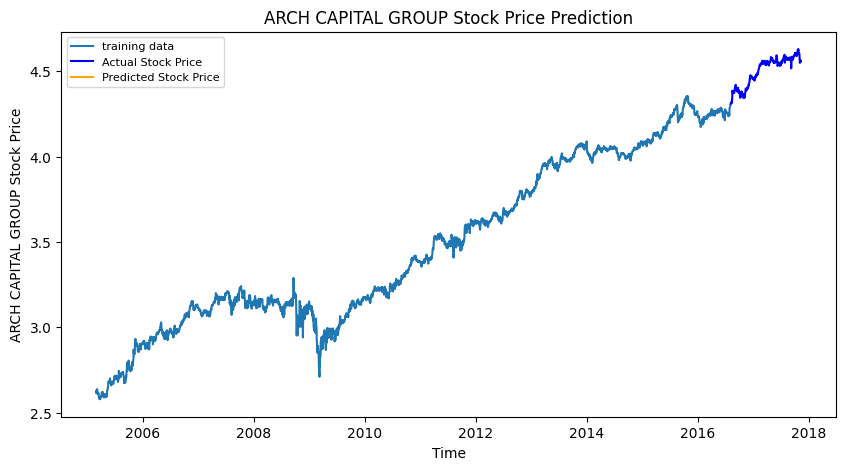

In [ ]:
# Forecast
forecast_obj = fitted.get_forecast(steps=321)
fc = forecast_obj.predicted_mean
conf = forecast_obj.conf_int(alpha=0.05)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test_data.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.10)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [38]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.05047164043356361
MAE: 0.20771790107058907
RMSE: 0.22465894247406135
MAPE: 0.025397463962705633
